In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skbio.stats.distance import permanova
from collections import Counter
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [2]:
mapping_file = pd.read_csv('../QIIME2.2/mapping_file/mapping_file.csv', index_col=0)
print(mapping_file.shape)
mapping_file.head()

(143, 42)


,genotype_1,fertility_1,amf,rep_1,group_1,shoot_mass,root_mass,total_mass,ratio_root_to_shoot,root_colonization,...,G_5,FERT_5,AMF,REP_5,group_5,Length,AvgDiam,Forks,SurfArea,Origin
#SampleID,,,,,,,,,,,,,,,,,,,,,
L1,1,P,Y,1,Common (C. dactylon),29.961,4.46,34.421,0.129572,43,...,1,P,Y,1,Common (C. dactylon),162.8464,0.2905,904.0,14.8643,African
L10,1,PPP,Y,2,Common (C. dactylon),26.283,10.16,36.443,0.278792,36,...,1,PPP,Y,2,Common (C. dactylon),329.7942,0.2978,2620.0,30.8595,African
L100,9,PP,Y,5,Common (C. dactylon),18.142,6.82,24.962,0.273215,21,...,9,PP,Y,5,Common (C. dactylon),229.4975,0.3495,1577.0,25.1969,Asian
L101,9,PP,Y,1,Common (C. dactylon),25.649,10.88,36.529,0.297846,26,...,9,PP,Y,1,Common (C. dactylon),216.1839,0.3708,1395.0,25.1835,Asian
L102,9,PP,Y,2,Common (C. dactylon),25.664,12.66,38.324,0.330341,39,...,9,PP,Y,2,Common (C. dactylon),302.0509,0.2743,1827.0,26.0297,Asian


In [5]:
otu_df = pd.read_csv('../QIIME2/exported-table-taxonomy/table.from_biom_w_taxonomy.txt', skiprows=1, sep = '\t', index_col=0)
# otu_df.drop('taxonomy', axis = 1, inplace = True)
otu_df = otu_df.T
otu_df = otu_df[otu_df.index.str.contains('L')]
low_reads_df = pd.DataFrame(otu_df.sum(axis = 1))
low_reads = low_reads_df[low_reads_df[0] < 1000].index
otu_df = otu_df[~otu_df.index.isin(low_reads)]
print(len(low_reads))
print(low_reads)
print(otu_df.shape)
otu_df

4
Index(['L92', 'LB3', 'LB5', 'LB9'], dtype='object')
(152, 65)


#OTU ID,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__MO-G17,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;__,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__Yamato09 A2,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__Glo45,k__fungi;p__Glomeromycota;c__Paraglomeromycetes;o__Paraglomerales;f__Paraglomeraceae;g__Paraglomus;s__Alguacil12a Para 1,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__Whitfield type 17,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__GCL-6,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__MO-G8,k__fungi;p__Glomeromycota;c__Paraglomeromycetes;o__Paraglomerales;f__Paraglomeraceae;g__Paraglomus;__,k__fungi;p__Glomeromycota;c__Glomeromycetes;__;__;__;__,...,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__Glo3,k__fungi;p__Glomeromycota;c__Paraglomeromycetes;o__Paraglomerales;f__Paraglomeraceae;g__Paraglomus;s__IS-Pg1,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__Glo-D,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__MO-G27,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__acnaGlo2,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__cf. microaggregatum,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Claroideoglomeraceae;g__Claroideoglomus;s__Glo59,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__MO-G14,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__INTA-4,k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__ORVIN GLO3B
L1,5556.0,515.0,457.0,519.0,0.0,33.0,0.0,153.0,57.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L10,2649.0,524.0,0.0,0.0,61.0,170.0,0.0,0.0,270.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L100,9868.0,161.0,51.0,186.0,7.0,0.0,0.0,50.0,249.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L101,482.0,8626.0,364.0,189.0,3554.0,0.0,268.0,620.0,574.0,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L102,9102.0,1029.0,5.0,114.0,0.0,28.0,0.0,523.0,57.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LB2,0.0,602.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LB4,863.0,2224.0,0.0,962.0,0.0,0.0,0.0,731.0,565.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LB6,0.0,2732.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LB7,0.0,418.0,1038.0,0.0,146.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
random_forest_df = pd.read_csv('../Data/Random forest importances.csv', )
taxa = list(random_forest_df['Taxa'].values)

In [12]:
lasso_df = mapping_file.copy()
lasso_df = lasso_df[lasso_df.index.isin(otu_df.index)]
lasso_df.sort_index(inplace = True)
otu_df.sort_index(inplace = True)
lasso_df_full = pd.concat([lasso_df, otu_df], axis=1)

1000.0


<AxesSubplot:>

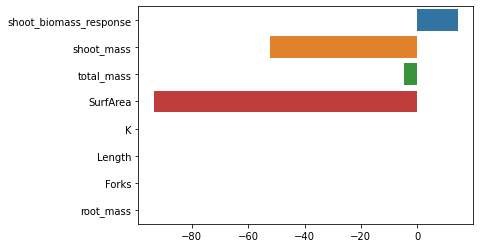

In [39]:
variable = taxa[3]
# landform = 'PG'
columns = ['shoot_biomass_response','shoot_mass','total_mass','SurfArea','K','Length','Forks','root_mass']

columns_target = columns.copy()
columns_target.append(variable)
lasso_df_full_target = lasso_df_full[columns_target].dropna()
target = lasso_df_full_target[variable]
features = lasso_df_full_target[columns]

lass_cv = LassoCV(alphas=[-100, -10, 0.1, 0.001, 0.0001, 1, 10, 100, 1000], tol = 10, max_iter = 100000)
model_cv = lass_cv.fit(features, target)
features_coef_df = pd.DataFrame(data = {'Coef': model_cv.coef_, 'Feature': features.columns})
print(model_cv.alpha_)
sns.barplot(x=model_cv.coef_, y = features.columns)

In [40]:
features_coef_df

,Coef,Feature
0,14.405898,shoot_biomass_response
1,-52.253283,shoot_mass
2,-4.852481,total_mass
3,-93.547614,SurfArea
4,-0.000000,K
5,-0.053743,Length
6,-0.093153,Forks
7,-0.000000,root_mass


<AxesSubplot:xlabel='shoot_biomass_response', ylabel='k__fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus;s__MO-G17'>

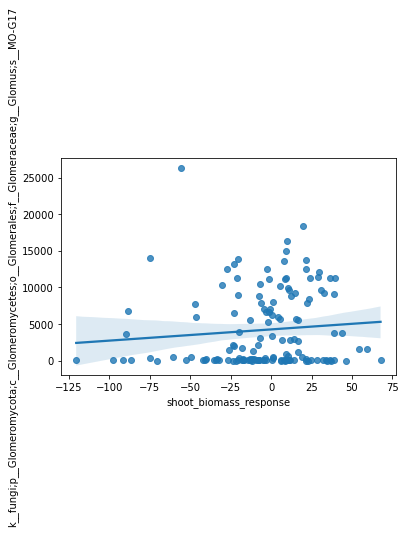

In [42]:
sns.regplot(y = variable, x = 'shoot_biomass_response', data = lasso_df_full_target)